# Analyse de l’accessibilité aux services urbains à Clamart

## Plan du projet

1. Introduction
2. Objectifs
3. Chargement des bibliothèques
4. Données et sources
5. Méthodologie
    5.1. Définition de la zone d’étude  
    5.2. Construction de la grille spatiale  
    5.3. Collecte des points d’intérêt (POI)  
6. Analyse exploratoire
    6.1. Répartition des écoles et crèches  
    6.2. Répartition des pharmacies  
    6.3. Répartition des commerces alimentaires  
    6.4. Répartition des cafés et restaurants  
    6.5. Répartition des parcs et espaces verts  
    6.6. Répartition des toilettes publiques  
    6.7. Répartition des bancs publics  
7. Synthèse des résultats
8. Visualisation cartographique
9. Recommandations
10. Limites et perspectives
11. Annexes (optionnel)


# 1. Introduction

L’aménagement d’une ville repose en grande partie sur la bonne répartition des services accessibles à la population. Pharmacies, écoles, commerces, espaces verts, sanitaires ou encore bancs publics sont des éléments essentiels du cadre de vie urbain. 

Clamart, commune des Hauts-de-Seine en région Île-de-France, connaît une évolution démographique constante et des enjeux de qualité de vie toujours plus présents. Dans ce contexte, il est pertinent d’analyser la répartition spatiale de ces services afin d’identifier les zones potentiellement sous-équipées.

Ce projet a pour objectif de fournir une vision cartographique et analytique de l’accessibilité aux services urbains à Clamart, à partir de données ouvertes issues d’OpenStreetMap.


# 2. Objectifs

L’analyse vise à répondre aux questions suivantes :

- Quels quartiers de Clamart sont les mieux ou les moins bien desservis par les services essentiels ?
- Existe-t-il des zones de concentration ou, au contraire, des « déserts » de services ?
- Peut-on identifier des zones prioritaires pour l’aménagement ou l’installation de nouveaux équipements ?

Les résultats pourront servir de base de réflexion pour les décideurs publics (collectivités locales), mais aussi pour les acteurs économiques (commerçants, investisseurs locaux) ou les habitants eux-mêmes.


# 3. Chargement des bibliothèques

In [1]:
# Bibliothèques générales
import pandas as pd
import numpy as np
import folium

# Bibliothèques géospatiales
import geopandas as gpd
from geopandas.tools import sjoin
import osmnx as ox
from osmnx import features
from shapely.geometry import box, Point

# Visualisation
import matplotlib.pyplot as plt

# Pour éviter les warnings
import warnings
warnings.filterwarnings("ignore")


# 4. Données et sources

Ce projet s’appuie exclusivement sur des données géographiques ouvertes provenant de la plateforme OpenStreetMap, accessibles via la bibliothèque Python `osmnx`.

Les données utilisées concernent principalement les points d’intérêt suivants (POI) :

- **Pharmacies** (`amenity = pharmacy`)
- **Écoles et crèches** (`amenity = school`, `kindergarten`)
- **Commerces alimentaires** (`shop = supermarket`, `convenience`)
- **Cafés et restaurants** (`amenity = cafe`, `restaurant`, `fast_food`)
- **Espaces verts** (`leisure = park`, `natural = wood`)
- **Toilettes publiques** (`amenity = toilets`)
- **Bancs publics** (`amenity = bench`)

La délimitation géographique de la commune de Clamart est également obtenue via OpenStreetMap.  
La ville est ensuite découpée en une grille régulière, chaque cellule représentant une portion homogène du territoire (~200 m de côté).

Ce découpage permet de comptabiliser les services disponibles dans chaque cellule et de produire des cartes thématiques.

# 5. Méthodologie

## 5.1. Définition de la zone d’étude

La commune de Clamart constitue le périmètre d’analyse. Sa géométrie administrative est récupérée via OpenStreetMap grâce à la bibliothèque `osmnx`.  
Elle est ensuite visualisée et utilisée comme base pour le découpage spatial.



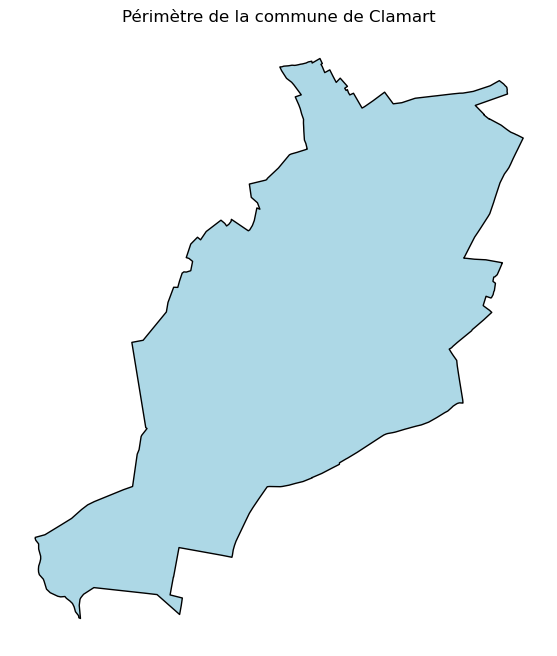

In [2]:


# Définition du nom de la commune à analyser
ville = "Clamart, France"

# Récupération de la géométrie administrative de Clamart via OpenStreetMap
clamart = ox.geocode_to_gdf(ville)

# Affichage rapide de la forme de la commune
clamart.plot(edgecolor='black', facecolor='lightblue', figsize=(8, 8))
plt.title("Périmètre de la commune de Clamart")
plt.axis("off")
plt.show()


## 5.2. Construction de la grille spatiale

Pour faciliter l’analyse, le territoire de Clamart est découpé en une grille de cellules carrées d’environ 200 mètres de côté.  
Chaque cellule permet d’agréger les points d’intérêt présents dans une même zone géographique.  
Ce découpage régulier offre une base neutre et homogène pour comparer les zones entre elles.



In [3]:
# Fonction pour créer une grille régulière à partir d’un polygone
def make_grid(polygon_gdf, cell_size=0.002):  # ~200 m
    polygon_gdf = polygon_gdf[~polygon_gdf.geometry.is_empty & polygon_gdf.geometry.notnull()]
    polygon_gdf = polygon_gdf[polygon_gdf.is_valid]
    crs = polygon_gdf.crs or "EPSG:4326"
    polygon_gdf = polygon_gdf.to_crs(crs)
    minx, miny, maxx, maxy = polygon_gdf.total_bounds
    x_coords = np.arange(minx, maxx, cell_size)
    y_coords = np.arange(miny, maxy, cell_size)
    grid_cells = [box(x, y, x + cell_size, y + cell_size) for x in x_coords for y in y_coords]
    grid = gpd.GeoDataFrame(geometry=grid_cells, crs=crs)
    grid = grid[grid.intersects(polygon_gdf.unary_union)]
    return grid.reset_index(drop=True)

grille = make_grid(clamart)
grille["id"] = grille.index

## 5.3 Collecte des points d’intérêt (POI)

Les services urbains que nous analysons sont extraits depuis OpenStreetMap à l’aide de la bibliothèque `osmnx`.  
Nous sélectionnons plusieurs catégories de points d’intérêt (POI), considérés comme essentiels pour la qualité de vie dans un quartier :

- Pharmacies
- Écoles et crèches
- Commerces alimentaires (supermarchés, épiceries)
- Cafés et restaurants
- Espaces verts
- Toilettes publiques
- Bancs publics

Nous ne conservons que les objets de type `Point`, plus faciles à agréger spatialement.


In [4]:
tags = {
    "amenity": ["pharmacy", "school", "kindergarten", "cafe", "restaurant", "toilets", "bench"],
    "shop": ["supermarket", "convenience"],
    "leisure": ["park"]
}
pois = features.features_from_place(ville, tags)
pois = pois[pois.geometry.type == "Point"]
pois = pois.to_crs(grille.crs)


In [5]:
# Aperçu rapide des types d’équipements récupérés
pois["amenity"].value_counts(dropna=False)

amenity
bench           101
restaurant       53
NaN              19
pharmacy         14
school            7
cafe              4
kindergarten      4
toilets           2
Name: count, dtype: int64

In [6]:
# ===  Ajout manuel d'écoles manquantes ===
ecoles_manquantes = [
    ["École Panorama", 48.791783224569855, 2.2682159423540216],
    # Ajouter d'autres ici si besoin
]

# Création d'un GeoDataFrame pour les écoles manuelles
ecoles_custom_geom = [Point(lon, lat) for _, lat, lon in ecoles_manquantes]
ecoles_custom = gpd.GeoDataFrame(
    {
        "amenity": ["school"] * len(ecoles_manquantes),
        "name": [nom for nom, _, _ in ecoles_manquantes],
        "geometry": ecoles_custom_geom
    },
    crs="EPSG:4326"
)
ecoles_custom = ecoles_custom.to_crs(grille.crs)




# 6. CREATE A TITLE

## 6.1 Analyse des écoles et crèches

L’accès à une école ou à une structure d’accueil pour les jeunes enfants est un facteur clé dans l’attractivité d’un quartier, notamment pour les familles.

Dans cette section, nous identifions les cellules de la grille qui contiennent un ou plusieurs établissements scolaires (`amenity = school`) ou crèches (`amenity = kindergarten`), et nous visualisons leur répartition.


In [7]:
# === 6. Filtrage des écoles + ajout des écoles manuelles ===
ecoles = pois[pois["amenity"].isin(["school", "kindergarten"])].copy()
ecoles = pd.concat([ecoles, ecoles_custom], ignore_index=True)

In [8]:
# === 7. Comptage des écoles par cellule ===
ecoles_joint = sjoin(ecoles, grille, how="left", predicate="within")
ecole_counts = ecoles_joint.groupby("index_right").size()
grille["ecoles"] = grille.index.map(ecole_counts).fillna(0).astype(int)

In [9]:
# === 8. Carte interactive avec Folium ===
center = [clamart.geometry.centroid.y.mean(), clamart.geometry.centroid.x.mean()]
m = folium.Map(location=center, zoom_start=14)

# Choropleth : nombre d'écoles
folium.Choropleth(
    geo_data=grille.__geo_interface__,
    data=grille,
    columns=["id", "ecoles"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Nombre d'écoles",
).add_to(m)

# Ajout de marqueurs pour TOUTES les écoles (y compris les manuelles)
for _, row in ecoles.iterrows():
    nom = row.get("name", "École ou crèche")
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=nom,
        icon=folium.Icon(color='blue', icon='graduation-cap', prefix='fa')
    ).add_to(m)

# Affichage de la carte interactive
m

### Interprétation des résultats

On observe une forte concentration d’écoles et de crèches dans le centre et le nord-est de Clamart.  
Certaines zones, notamment en périphérie sud-ouest, présentent une **absence totale d’équipements scolaires** dans leur cellule.  
Cela peut indiquer des **besoins potentiels en structures éducatives** ou une couverture insuffisante pour les familles résidant dans ces quartiers.

Il serait pertinent de croiser ces résultats avec des données de population pour affiner les recommandations.


## 6.2 Analyse des pharmacies

L’accès rapide à une pharmacie est un enjeu de santé publique, notamment pour les populations âgées, les urgences mineures ou les zones peu médicalisées.

Dans cette section, nous analysons la répartition spatiale des pharmacies (`amenity = pharmacy`) sur le territoire de Clamart afin d’identifier les zones bien ou mal desservies.


In [10]:
# === Filtrage des pharmacies ===
pharmacies = pois[pois["amenity"] == "pharmacy"].copy()

# === Jointure spatiale avec la grille ===
pharmacies_joint = sjoin(pharmacies, grille, how="left", predicate="within")

# === Comptage par cellule ===
pharma_counts = pharmacies_joint.groupby("index_right").size()
grille["pharmacies"] = grille.index.map(pharma_counts).fillna(0).astype(int)


In [11]:
# Carte Folium pour les pharmacies
m2 = folium.Map(location=center, zoom_start=14)

# Couche choroplèthe
folium.Choropleth(
    geo_data=grille.__geo_interface__,
    data=grille,
    columns=["id", "pharmacies"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Nombre de pharmacies",
).add_to(m2)

# Marqueurs cliquables pour chaque pharmacie
for _, row in pharmacies.iterrows():
    nom = row.get("name", "Pharmacie")
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=nom,
        icon=folium.Icon(color="green", icon="plus", prefix="fa")  # ✅ icône visible sur la carte
    ).add_to(m2)
m2


### Interprétation des résultats

La carte révèle une **concentration importante de pharmacies dans les zones centrales et sud-ouest de Clamart**, notamment autour des grands axes routiers et des zones commerciales.

À l’inverse, certaines cellules situées en **périphérie nord-ouest et sud-est** n’abritent aucune pharmacie à proximité directe.  
Cela peut poser problème pour les populations âgées, les personnes à mobilité réduite ou les habitants sans véhicule.

La commune pourrait envisager :
- une meilleure répartition géographique lors de futures implantations,
- ou la mise en place de **services de livraison** ou **de garde mobile** dans les zones sous-desservies.

Une analyse croisée avec la **densité de population** ou la **présence de structures médicales** permettrait de confirmer ces observations.


## 6.3 Analyse des commerces alimentaires

L'accès à une alimentation de proximité est un facteur clé pour la qualité de vie des habitants, notamment pour les personnes âgées ou sans véhicule.

Dans cette section, nous analysons la présence de :
- **supermarchés** (`shop = supermarket`)
- **épiceries de quartier** (`shop = convenience`)

et leur répartition sur le territoire de Clamart.


In [12]:
# === Filtrage des commerces alimentaires ===
supermarches = pois[pois["shop"] == "supermarket"].copy()
epiceries = pois[pois["shop"] == "convenience"].copy()

# Jointure spatiale
super_joint = sjoin(supermarches, grille, how="left", predicate="within")
epi_joint = sjoin(epiceries, grille, how="left", predicate="within")

# Comptage
super_counts = super_joint.groupby("index_right").size()
epi_counts = epi_joint.groupby("index_right").size()

# Ajout dans la grille
grille["supermarches"] = grille.index.map(super_counts).fillna(0).astype(int)
grille["epiceries"] = grille.index.map(epi_counts).fillna(0).astype(int)

# Créer la colonne alimentation comme somme de supermarchés + épiceries
grille["alimentation"] = grille["supermarches"] + grille["epiceries"]


In [13]:
# === Carte combinée : alimentation ===
m_combined = folium.Map(location=center, zoom_start=14)

# Choropleth combiné : supermarchés + épiceries
choropleth = folium.Choropleth(
    geo_data=grille.__geo_interface__,
    data=grille[["id", "alimentation"]],
    columns=["id", "alimentation"],
    key_on="feature.id",
    fill_color="YlOrBr",
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name="Nombre total de commerces alimentaires"
)

# ✅ Donner un nom lisible à la couche choropleth
choropleth.layer_name = "Grid"
choropleth.add_to(m_combined)

# --- Supermarchés ---
fg_super = folium.FeatureGroup(name="Supermarchés")
for _, row in supermarches.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row.get("name", "Supermarché"),
        icon=folium.Icon(color="darkred", icon="shopping-cart", prefix="fa")
    ).add_to(fg_super)
fg_super.add_to(m_combined)

# --- Épiceries ---
fg_epi = folium.FeatureGroup(name="Épiceries")
for _, row in epiceries.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row.get("name", "Épicerie"),
        icon=folium.Icon(color="green", icon="shopping-basket", prefix="fa")
    ).add_to(fg_epi)
fg_epi.add_to(m_combined)

# --- Contrôle des couches ---
folium.LayerControl(collapsed=False).add_to(m_combined)

# Affichage de la carte
m_combined


### Interprétation des résultats – Carte combinée : commerces alimentaires

La carte combinée permet de visualiser **l'accessibilité globale aux commerces alimentaires** à Clamart, en agrégeant les supermarchés et les épiceries.

On constate que :

- Les **zones centrales et sud-est** sont les mieux desservies, avec une **concentration importante** de points de vente alimentaires.
- Les **zones périphériques nord-ouest et sud-ouest** présentent des **déserts alimentaires**, avec une couverture très faible voire inexistante.

Ces inégalités d’accès peuvent avoir un **impact sur les habitudes de consommation**, en particulier pour les populations les plus vulnérables ou à mobilité réduite.

Des recommandations pourraient inclure :

- L’**implantation ciblée de nouveaux commerces de proximité** dans les zones déficitaires,
- Le développement de **services itinérants ou de livraison**,
- Une **concertation avec les habitants** pour comprendre les besoins réels et adapter l’offre.

Cette visualisation croisée met en lumière l’importance d’un **aménagement du territoire équitable** pour assurer un accès à une alimentation de qualité sur l’ensemble du territoire communal.


In [15]:
# === 9. Création d'un tableau global de couverture par cellule ===
from collections import defaultdict

def compter_par_categorie(gdf, colonne_categorie, valeur, grille):
    subset = gdf[gdf[colonne_categorie] == valeur].copy()
    joint = sjoin(subset, grille, how="left", predicate="within")
    counts = joint.groupby("index_right").size()
    return grille.index.map(counts).fillna(0).astype(int)

# Catégories à compter
categories = {
    "ecoles": (ecoles, None),
    "pharmacies": (pois, "pharmacy"),
    "cafes": (pois, "cafe"),
    "toilettes": (pois, "toilets"),
    "bancs": (pois, "bench"),
    "supermarches": (pois, "supermarket"),
    "epiceries": (pois, "convenience"),
    "parcs": (pois, "park"),
}

# Initialiser la table
grille_multi = grille.copy()

# Remplir la table
for nom_col, (gdf, valeur) in categories.items():
    if valeur:
        grille_multi[nom_col] = compter_par_categorie(gdf, "amenity" if "amenity" in gdf.columns else "shop" if "shop" in gdf.columns else "leisure", valeur, grille)
    else:
        grille_multi[nom_col] = compter_par_categorie(gdf, "amenity", "school", grille)

# Aperçu du tableau final
display(grille_multi[["id"] + list(categories.keys())].head())

display(pois["amenity"].value_counts())



,id,ecoles,pharmacies,cafes,toilettes,bancs,supermarches,epiceries,parcs
0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0


amenity
bench           101
restaurant       53
pharmacy         14
school            7
cafe              4
kindergarten      4
toilets           2
Name: count, dtype: int64

# 7. Analyse croisee : Densite de population vs Accessibilite aux services 

In [4]:
import pandas as pd

# Charger le fichier CSV décompressé
df_pop = pd.read_csv("./Data/base-ic-evol-struct-pop-2021.CSV", sep=";", dtype=str)

# Aperçu rapide
df_pop.head()


,IRIS,COM,TYP_IRIS,LAB_IRIS,P21_POP,P21_POP0002,P21_POP0305,P21_POP0610,P21_POP1117,P21_POP1824,...,C21_F15P_CS4,C21_F15P_CS5,C21_F15P_CS6,C21_F15P_CS7,C21_F15P_CS8,P21_POP_FR,P21_POP_ETR,P21_POP_IMM,P21_PMEN,P21_PHORMEN
0,010010000,01001,Z,5,832,32.2221772688278,27.4379832465365,54.8418453729531,79.1699499433284,29.1297982157669,...,48.2680435004782,82.3007100121866,29.0214931283286,86.221403536789,29.019651024327,822.287126066005,9.71287393399538,18.3810100778466,832,0
1,010020000,01002,Z,5,267,5.98777321691745,12.0677762450347,19.0664665554135,34.0503178683653,11.2438158191622,...,24.6124385140641,14.6697489149311,4.74083957141047,23.5611051647164,4.74083957141047,265.991895260245,1.00810473975459,2.87582202985159,267,0
2,010040101,01004,H,1,1796.95177430624,77.5196784610302,43.9744055740572,98.9160602098838,122.511552505057,349.080836127386,...,86.4761621548466,260.72995024309,37.6548304638921,188.843990999457,121.113704137328,1538.64616952,258.305604786245,211.46919308125,1433.95063343904,363.001140867201
3,010040102,01004,H,1,3837.42180628153,148.643017453466,157.192811724813,250.217019514518,321.725625394565,386.552427731942,...,175.460726651299,393.281535281922,131.385823620787,380.956439836897,311.474727593598,3276.84492299519,560.576883286342,704.822357703352,3837.42180628153,0
4,010040201,01004,H,1,4393.22827105268,188.02159494229,181.999302911125,251.490069962966,393.474367883351,374.897947132119,...,306.60355083175,474.298206799531,188.919251684586,607.301110129541,366.13677833831,3939.7989788968,453.42929215588,476.166500306299,4305.22799447882,88.0002765738669


In [9]:
# Filtrer uniquement Clamart

df_clamart = df_pop[df_pop["IRIS"].str.startswith("92023")]
display(df_clamart.info())

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 46427 to 46447
Data columns (total 76 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   IRIS            21 non-null     object
 1   COM             21 non-null     object
 2   TYP_IRIS        21 non-null     object
 3   LAB_IRIS        21 non-null     object
 4   P21_POP         21 non-null     object
 5   P21_POP0002     21 non-null     object
 6   P21_POP0305     21 non-null     object
 7   P21_POP0610     21 non-null     object
 8   P21_POP1117     21 non-null     object
 9   P21_POP1824     21 non-null     object
 10  P21_POP2539     21 non-null     object
 11  P21_POP4054     21 non-null     object
 12  P21_POP5564     21 non-null     object
 13  P21_POP6579     21 non-null     object
 14  P21_POP80P      21 non-null     object
 15  P21_POP0014     21 non-null     object
 16  P21_POP1529     21 non-null     object
 17  P21_POP3044     21 non-null     object
 18  P21_POP455

None

KeyError: 'LIBCOM'